['AMERICAN GOLDFINCH' 'AMERICAN ROBIN' 'BLACK-CAPPED CHICKADEE'
 'CEDAR WAXWING' 'CHIPPING SPARROW' 'COMMON GRACKLE' 'DARK EYED JUNCO'
 'DOWNY WOODPECKER' 'HOUSE SPARROW' 'MALLARD DUCK' 'MOURNING DOVE'
 'NORTHERN CARDINAL' 'NORTHERN FLICKER' 'PURPLE FINCH' 'TREE SWALLOW']
15
labels
DARK EYED JUNCO           203
TREE SWALLOW              181
CEDAR WAXWING             180
COMMON GRACKLE            177
CHIPPING SPARROW          162
DOWNY WOODPECKER          157
HOUSE SPARROW             155
NORTHERN CARDINAL         155
MOURNING DOVE             153
PURPLE FINCH              153
AMERICAN ROBIN            147
NORTHERN FLICKER          139
MALLARD DUCK              135
AMERICAN GOLDFINCH        133
BLACK-CAPPED CHICKADEE    133
Name: count, dtype: int64
labels
AMERICAN GOLDFINCH        5
AMERICAN ROBIN            5
BLACK-CAPPED CHICKADEE    5
CEDAR WAXWING             5
CHIPPING SPARROW          5
COMMON GRACKLE            5
DARK EYED JUNCO           5
DOWNY WOODPECKER          5
HOUSE SPAR

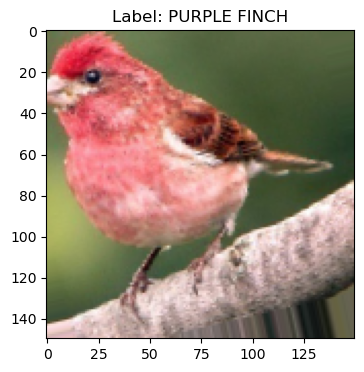

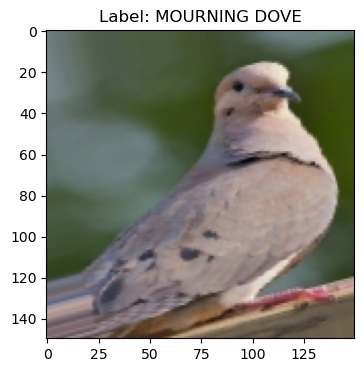

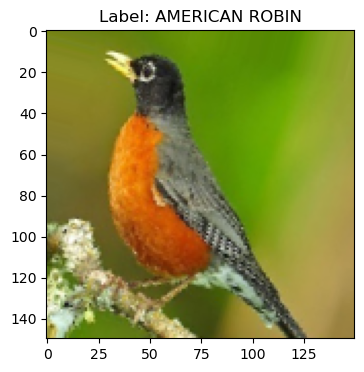

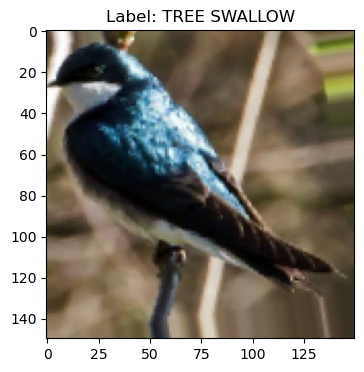

Batch 2
Image shape: (32, 150, 150, 3)
Label shape: (32, 15)


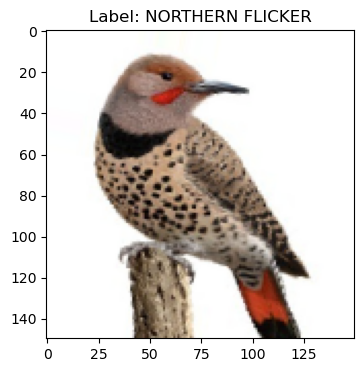

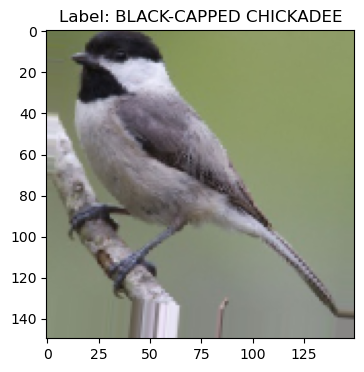

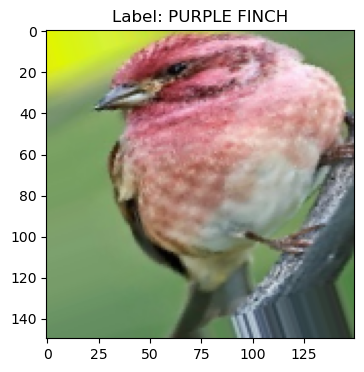

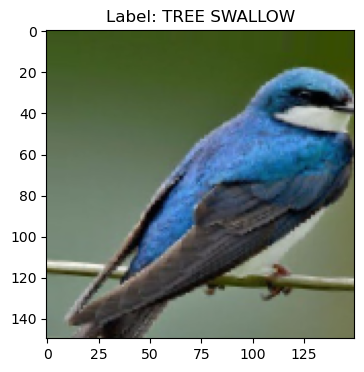

Batch 3
Image shape: (11, 150, 150, 3)
Label shape: (11, 15)


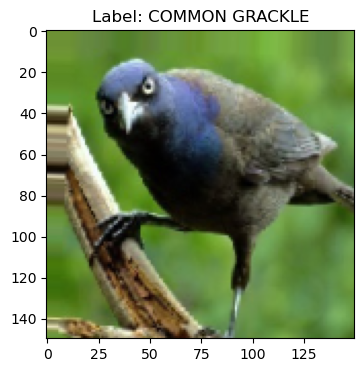

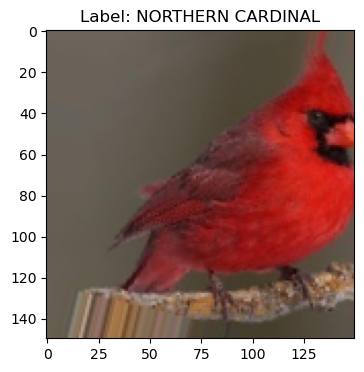

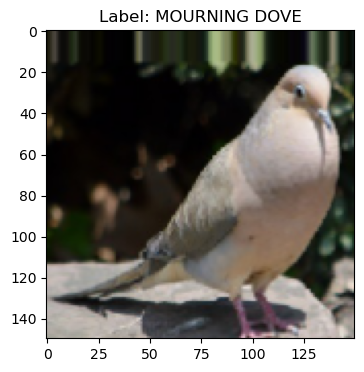

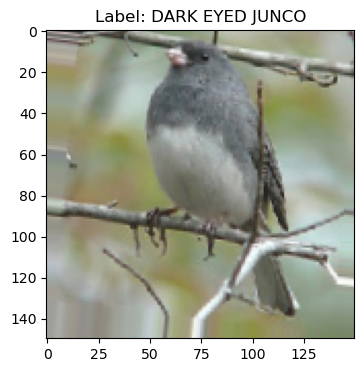

In [21]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
import efficientnet.keras as efn
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import Sequence
from keras.models import load_model
import streamlit as st
from sklearn.metrics import accuracy_score, classification_report
from keras.preprocessing import image

df = pd.read_csv('birds.csv')
df['data set'].value_counts()

# Bird choices
BIRDS_FROM_QUEBEC = (
    "BLACK-CAPPED CHICKADEE", "MALLARD DUCK", "AMERICAN ROBIN", "AMERICAN GOLDFINCH",
    "NORTHERN CARDINAL", "DOWNY WOODPECKER", "MOURNING DOVE", "HOUSE SPARROW",
    "COMMON GRACKLE", "DARK EYED JUNCO", "CHIPPING SPARROW", "NORTHERN FLICKER",
    "CEDAR WAXWING", "TREE SWALLOW", "PURPLE FINCH"
)

# Filtering for our species of bird
df_QC = df[df['labels'].isin(BIRDS_FROM_QUEBEC)]

# Display unique labels and their count
print(df_QC['labels'].unique())
print(len(df_QC['labels'].unique()))

# Display value counts for 'class id'
df_QC['class id'].value_counts()

# Splitting for train, test, and valid 
df_QC_TRAIN = df_QC[df_QC['data set'] == 'train']
df_QC_TEST = df_QC[df_QC['data set'] == 'test']
df_QC_VALID = df_QC[df_QC['data set'] == 'valid']

# Check class balance
print(df_QC_TRAIN['labels'].value_counts())
print(df_QC_TEST['labels'].value_counts())

print(len(BIRDS_FROM_QUEBEC))  # Should print 15

image_size = (150, 150)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Reduced from 40
    width_shift_range=0.1,  # Reduced from 0.2
    height_shift_range=0.1,  # Reduced from 0.2
    shear_range=0.1,  # Reduced from 0.2
    zoom_range=0.1,  # Reduced from 0.2
    horizontal_flip=True,
    fill_mode='nearest'
)

# DataFrameIterator for training and validation with adjusted augmentation
train_generator = datagen.flow_from_dataframe(
    dataframe=df_QC_TRAIN,
    directory=None,
    x_col='filepaths',
    y_col='labels',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=df_QC_TEST,
    directory=None,
    x_col='filepaths',
    y_col='labels',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Mapping birds
class_indices = {v: k for k, v in train_generator.class_indices.items()}

# Debugging the data generator by printing some validation batches
for i in range(3):  # Print the first 3 validation batches
    x_batch, y_batch = next(validation_generator)
    print(f"Batch {i+1}")
    print(f"Image shape: {x_batch.shape}")
    print(f"Label shape: {y_batch.shape}")

    # Visualize a few images from the batch
    for j in range(4):
        plt.figure(figsize=(4, 4))
        plt.imshow(x_batch[j])
        plt.title(f"Label: {class_indices[np.argmax(y_batch[j])]}")
        plt.show()

In [2]:
# EfficientNet excluding top info
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(150, 150, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the base model
base_model.trainable = False

# Adding custom layers on base model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Preventing regularization
    tf.keras.layers.Dense(len(BIRDS_FROM_QUEBEC), activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Set up callbacks for early stopping and saving the best model in .keras format
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)
]

# Training
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,  # Random choice
    callbacks=callbacks
)

# Unfreeze the top layers of the base model
base_model.trainable = True

# Re-compiling the model with a slightly higher learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tuning the model
fine_tune_history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,  # Fewer epochs for fine-tuning
    callbacks=callbacks
)

Epoch 1/50


C:\Users\User\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


74/74 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.0630 - loss: 2.7518 - val_accuracy: 0.0667 - val_loss: 2.7081
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 48s 631ms/step - accuracy: 0.0717 - loss: 2.7076 - val_accuracy: 0.0667 - val_loss: 2.7091
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 42s 547ms/step - accuracy: 0.0931 - loss: 2.7046 - val_accuracy: 0.0667 - val_loss: 2.7086
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 42s 552ms/step - accuracy: 0.0849 - loss: 2.7037 - val_accuracy: 0.0667 - val_loss: 2.7090
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 41s 544ms/step - accuracy: 0.0855 - loss: 2.7056 - val_accuracy: 0.0667 - val_loss: 2.7093
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 39s 507ms/step - accuracy: 0.0874 - loss: 2.7036 - val_accuracy: 0.0667 - val_loss: 2.7097
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 41s 542ms/step - accuracy: 0.0944 - loss: 2.7018 - val_accuracy: 0.0667 - val_loss: 2.7101
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 40s 515ms/step - accuracy: 0.0892 - loss: 2.7025 - val_accuracy: 0.0667 

In [3]:
# Evaluating model
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 364ms/step - accuracy: 1.0000 - loss: 3.4400e-05
Test Accuracy: 1.0000
Test Loss: 0.0000


In [4]:
# Save the model
model.save('fine_tuned_model.h5')

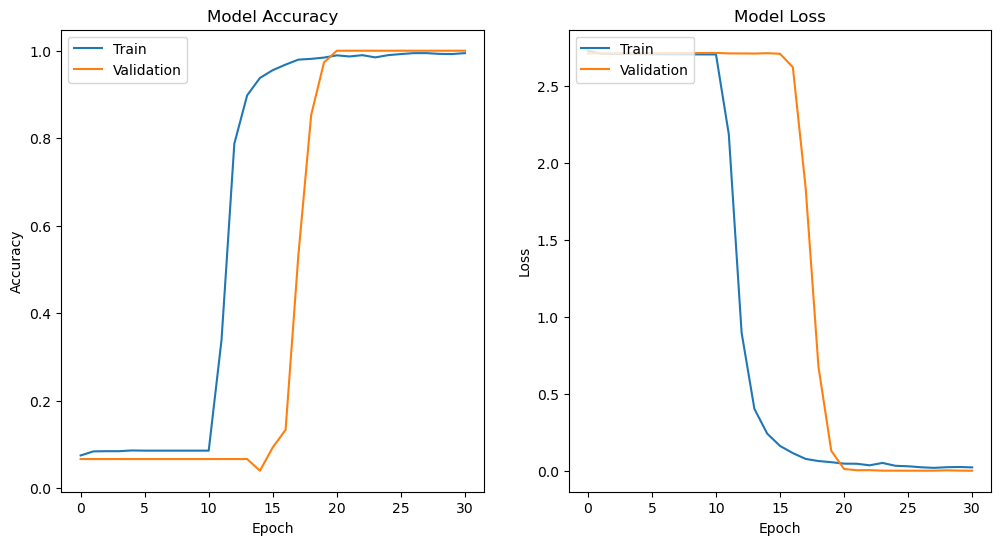

In [5]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + fine_tune_history.history['accuracy'])
plt.plot(history.history['val_accuracy'] + fine_tune_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + fine_tune_history.history['loss'])
plt.plot(history.history['val_loss'] + fine_tune_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

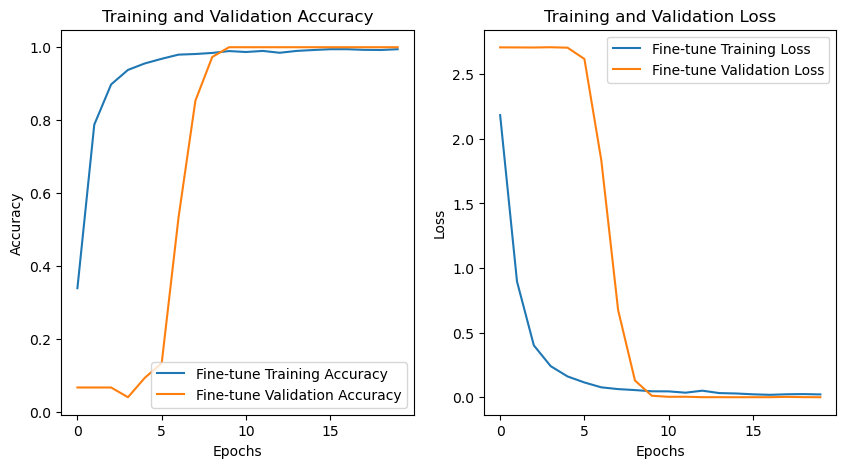

In [6]:
# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fine_tune_history.history['accuracy'], label='Fine-tune Training Accuracy')
plt.plot(fine_tune_history.history['val_accuracy'], label='Fine-tune Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(fine_tune_history.history['loss'], label='Fine-tune Training Loss')
plt.plot(fine_tune_history.history['val_loss'], label='Fine-tune Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [7]:
# Evaluate the model on the validation set
validation_loss, validation_accuracy = model.evaluate(validation_generator)

print(f"Validation Loss: {validation_loss}")
print(f"Validation Accuracy: {validation_accuracy * 100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step - accuracy: 1.0000 - loss: 6.8102e-05
Validation Loss: 6.319486419670284e-05
Validation Accuracy: 100.00%


In [17]:

# Create the data generator for unseen data
unseen_datagen = ImageDataGenerator(rescale=1./255)

# Assuming your test images are in 'test_data_dir'
unseen_generator = unseen_datagen.flow_from_dataframe(
    dataframe=df_QC_VALID,
    directory=None,
    x_col='filepaths',
    y_col='labels',
    subset=None,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important to keep the order for evaluation
)

# Make predictions
y_pred = model.predict(unseen_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Get true labels
y_true = unseen_generator.classes

# Evaluate the model
accuracy = accuracy_score(y_true, y_pred_classes)
print(f'Accuracy: {accuracy}')

# Detailed classification report
print(classification_report(y_true, y_pred_classes, target_names=unseen_generator.class_indices.keys()))

Found 75 validated image filenames belonging to 15 classes.


C:\Users\User\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step
Accuracy: 0.9866666666666667
                        precision    recall  f1-score   support

    AMERICAN GOLDFINCH       1.00      1.00      1.00         5
        AMERICAN ROBIN       1.00      1.00      1.00         5
BLACK-CAPPED CHICKADEE       1.00      1.00      1.00         5
         CEDAR WAXWING       1.00      1.00      1.00         5
      CHIPPING SPARROW       1.00      0.80      0.89         5
        COMMON GRACKLE       1.00      1.00      1.00         5
       DARK EYED JUNCO       1.00      1.00      1.00         5
      DOWNY WOODPECKER       1.00      1.00      1.00         5
         HOUSE SPARROW       0.83      1.00      0.91         5
          MALLARD DUCK       1.00      1.00      1.00         5
         MOURNING DOVE       1.00      1.00      1.00         5
     NORTHERN CARDINAL       1.00      1.00      1.00         5
      NORTHERN FLICKER       1.00      1.00      1.00         5
          PURPLE FINCH       1.00  

In [31]:
# Load your trained model
model = load_model('fine_tuned_model.h5')

# Create the ImageDataGenerator
unseen_datagen = ImageDataGenerator(rescale=1./255)

#Storing the labels
class_indices = {v: k for k, v in unseen_generator.class_indices.items()}

def predict_image_class(img_path):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(150, 150))  # Replace with your image size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Apply the same preprocessing
    img_array = unseen_datagen.standardize(img_array)

    # Make prediction
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)

    # Map the predicted class to the class label
    predicted_label = class_indices[predicted_class[0]]

    return predicted_label

# Example usage
img_path = 'valid/AMERICAN GOLDFINCH/1.jpg'
actual_class = 'AMERICAN GOLDFINCH'  # Replace with the actual class label
predicted_label= predict_image_class(img_path)
print(f'Predicted class: {predicted_label}, Actual class: {actual_class}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: AMERICAN GOLDFINCH, Actual class: AMERICAN GOLDFINCH


In [27]:
# Loop through the DataFrame and predict classes
results = []
for index, row in df_QC_VALID.iterrows():
    img_path = row['filepaths']
    actual_class = row['labels']
    predicted_class = predict_image_class(img_path)
    results.append({'filepaths': img_path, 'actual_class': actual_class, 'predicted_class': predicted_class})

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
print(results_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

In [30]:
# Compare actual and predicted classes
comparison = results_df['actual_class'] == results_df['predicted_class']
miss = results_df[results_df['actual_class'] != results_df['predicted_class']]
# Count the number of True and False values
counts = comparison.value_counts()
print(counts)
print(miss)


True     74
False     1
Name: count, dtype: int64
                       filepaths      actual_class predicted_class
20  valid/CHIPPING SPARROW/5.jpg  CHIPPING SPARROW   HOUSE SPARROW
